# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


# Preparing Dataset

In [2]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [3]:
def prepare_dataset(fname):
    raw_df = load_dataset(fname)
    
    if set(['file']).issubset(raw_df.columns):
        raw_df = raw_df.drop(['file'], axis=1)
    if set(['macro']).issubset(raw_df.columns):
        raw_df = raw_df.drop(['macro'], axis=1)
    
    df = raw_df.copy()

    df = df.drop(['A1', 'A1prime'], axis=1)
    is_na = df['A3'].isna() 
    df = df.loc[~is_na, :] #REMOVE ALL A3 NAN
    #df['euct'] = (df['eutectoid'].map(lambda x: 1 if x == 'hiper' else 0))
    df= df.drop(['eutectoid'], axis=1) #REMOVE EUCTETOID COLLUMN BECAUSE IT'S A STRING
    
    return df

In [4]:
def normalize_all_data(df):
    scaler = MinMaxScaler(feature_range=[-1, 1])
    scaler.fit(df)
    df.loc[:, :] = scaler.transform(df)
    return df

In [5]:
def split_between_train_and_test(df, size):
    #train size may be 0.8, 0.7 or 0.99
    target = df['A3']
    features = df.iloc[:, :20]
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        train_size=size,
        random_state=42
    )
    
    X_train = X_train.drop(['A3'], axis=1)
    X_test = X_test.drop(['A3'], axis=1)
    
    print('Train size: {}'.format(X_train.shape))
    print('Test size: {}'.format(X_test.shape))
    return X_train, y_train, X_test, y_test

In [6]:
df = prepare_dataset('../../databases/Tcriticalcopy.csv')
df = normalize_all_data(df)
df.head()

,C,Mn,Si,Cr,Ni,A3
0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,0.030744
1,-1.0,-1.0,-1.0,-1.0,-5.000000e-01,-0.100664
2,-1.0,-1.0,-1.0,-1.0,-2.220446e-16,-0.213736
3,-1.0,-1.0,-1.0,-1.0,5.000000e-01,-0.312742
4,-1.0,-1.0,-1.0,-1.0,1.000000e+00,-0.400445


In [7]:
X_train, y_train, X_test, y_test = split_between_train_and_test(df, 0.8)

Train size: (5476, 5)
Test size: (1369, 5)


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# The Model

In [25]:
# Creating a KERAS model
model = Sequential()
model.add(Dense(6, input_dim=5, activation='tanh'))
model.add(Dense(1, activation='tanh'))

In [26]:
# Adding callback functions that they will run in every epoch
# testmodelcb = keras.callbacks.LambdaCallback(on_epoch_end=save_model_prediction_graph)

In [27]:
# opt = optimizers.sgd(lr=.1, momentum=0)
opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# opt = optimizers.Adamax()

model.compile(loss='mean_squared_error', optimizer=opt)
loss = []

In [28]:
history = model.fit(X_train, y_train, epochs=100, verbose=1)
loss += history.history['loss']

Epoch 1/50
5476/5476 [==============================] - 0s 64us/step - loss: 0.3988
Epoch 2/50
5476/5476 [==============================] - 0s 31us/step - loss: 0.1344
Epoch 3/50
5476/5476 [==============================] - 0s 32us/step - loss: 0.0583
Epoch 4/50
5476/5476 [==============================] - 0s 34us/step - loss: 0.0519
Epoch 5/50
5476/5476 [==============================] - 0s 36us/step - loss: 0.0487
Epoch 6/50
5476/5476 [==============================] - 0s 33us/step - loss: 0.0444
Epoch 7/50
5476/5476 [==============================] - 0s 31us/step - loss: 0.0388
Epoch 8/50
5476/5476 [==============================] - 0s 32us/step - loss: 0.0326
Epoch 9/50
5476/5476 [==============================] - 0s 32us/step - loss: 0.0270
Epoch 10/50
5476/5476 [==============================] - 0s 33us/step - loss: 0.0227
Epoch 11/50
5476/5476 [==============================] - 0s 32us/step - loss: 0.0196
Epoch 12/50
5476/5476 [==============================] - 0s 33us/step - lo

Test loss (mean squared error): 0.008726324080275284


Text(0, 0.5, 'Expected values')

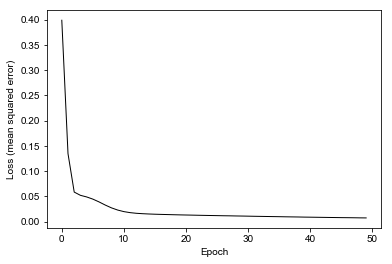

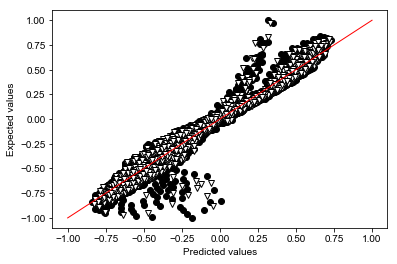

In [30]:
fig, ax = plt.subplots()

ax.plot(loss, color='k', label='Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (mean squared error)')

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss (mean squared error):', score)

fig, ax = plt.subplots()
ax.plot(model.predict(X_train), y_train, 'ko')
ax.plot(model.predict(X_test), y_test, 'kv', mfc='white')
ax.plot([-1,1],[-1,1],'r-')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Expected values')